In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_train = (x_train - 127.5) / 127.5

def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model


# Define discriminator
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Define GAN
class GAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        generated_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            all_images = tf.concat([generated_images, real_images], axis=0)
            labels = tf.concat([generated_labels, tf.ones((batch_size, 1))], axis=0)
            preds = self.discriminator(all_images)
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            preds = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, preds)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

# Set up GAN
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile GAN
gan.compile(d_optimizer=optimizers.Adam(learning_rate=0.0002),
            g_optimizer=optimizers.Adam(learning_rate=0.0002),
            loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# Train GAN
gan.fit(x_train, batch_size=128, epochs=30)


Epoch 1/30
469/469 [==============================] - 15s 20ms/step - d_loss: 0.2338 - g_loss: 2.4128
Epoch 2/30
469/469 [==============================] - 9s 19ms/step - d_loss: 0.3195 - g_loss: 2.6850
Epoch 3/30
469/469 [==============================] - 9s 19ms/step - d_loss: 0.3736 - g_loss: 2.1542
Epoch 4/30
469/469 [==============================] - 9s 19ms/step - d_loss: 0.3049 - g_loss: 1.9100
Epoch 5/30
469/469 [==============================] - 9s 19ms/step - d_loss: 0.2971 - g_loss: 1.8525
Epoch 6/30
469/469 [==============================] - 9s 20ms/step - d_loss: 0.3335 - g_loss: 1.8438
Epoch 7/30
469/469 [==============================] - 9s 20ms/step - d_loss: 0.3539 - g_loss: 1.8000
Epoch 8/30
469/469 [==============================] - 9s 20ms/step - d_loss: 0.3400 - g_loss: 1.7404
Epoch 9/30
469/469 [==============================] - 9s 20ms/step - d_loss: 0.3679 - g_loss: 1.8114
Epoch 10/30
469/469 [==============================] - 9s 20ms/step - d_loss: 0.3884 - g_l

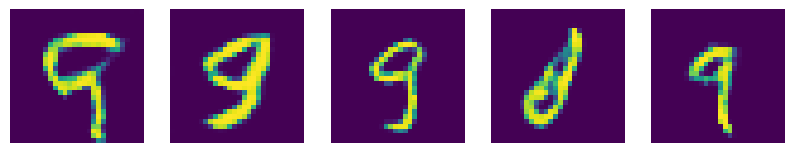

In [5]:
import matplotlib.pyplot as plt

# Generate and plot images
def generate_and_plot_images(generator, latent_dim, num_images=5):
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    generated_images = generator(random_latent_vectors)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow((generated_images[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        axes[i].axis('off')
    plt.show()

# Generate images after training
generate_and_plot_images(generator, latent_dim)


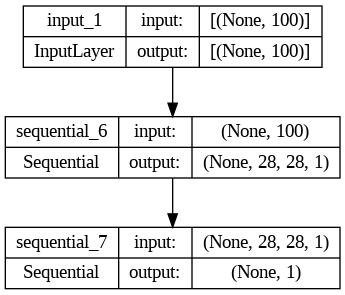

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define input for generator
generator_input = Input(shape=(latent_dim,))
# Generate output from generator
generator_output = generator(generator_input)

# Define input for discriminator
discriminator_input = Input(shape=(28, 28, 1,))
# Discriminator output
gan_output = discriminator(generator_output)

# Create GAN model
gan = Model(generator_input, gan_output)

# Visualize GAN
plot_model(gan, to_file='gan.png', show_shapes=True, show_layer_names=True)


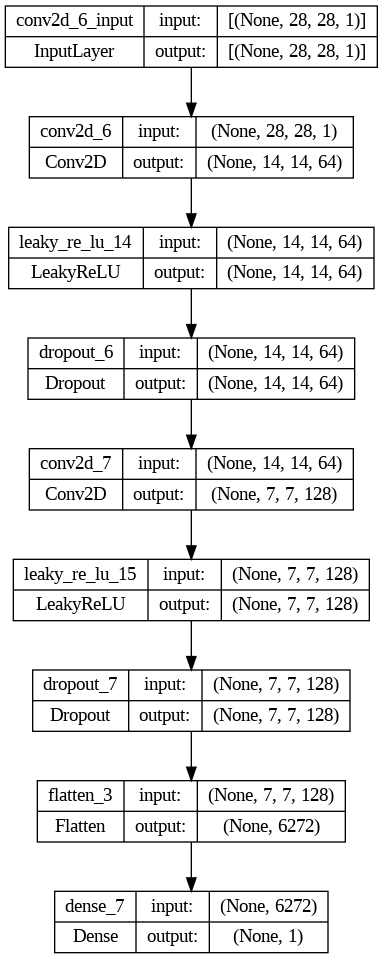

In [9]:
from tensorflow.keras.utils import plot_model


# Visualize discriminator
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)


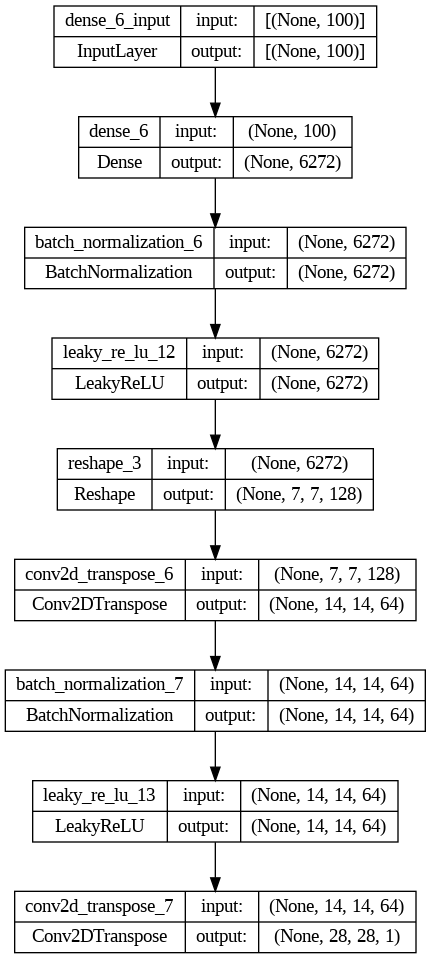

In [10]:
# Visualize generator
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True)
